In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd

# Selección de modelos

In [2]:
# Datos
cars = pd.read_csv('mtcars.csv')
cars.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [3]:
X = cars['wt'].values.reshape(-1,1)
y = cars['mpg'].values

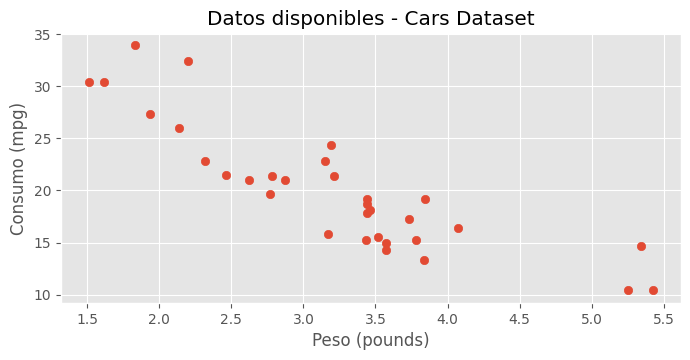

In [4]:
# Gráfica de datos de entrenamiento
plt.figure(figsize=(8,3.5))
plt.scatter(X, y, label='Datos', zorder=3)
plt.ylabel('Consumo (mpg)')
plt.xlabel('Peso (pounds)')
plt.title('Datos disponibles - Cars Dataset')
#plt.savefig('Ejemplo_CARS.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

In [6]:
depth_list = [1, 2, 3, 4, 5, None]
mse_train_vals = []
mse_cv_vals = []

for depth in depth_list:
    # Crear arbol
    tree = DecisionTreeRegressor(max_depth=depth)

    # Evaluamos
    scores = cross_validate(tree, X, y, cv=32,
                            return_train_score=True ,
                            scoring='neg_mean_squared_error'
                            )
    mse_train = -np.mean(scores['train_score'])
    mse_cv = -np.mean(scores['test_score'])

    mse_train_vals.append(mse_train)
    mse_cv_vals.append(mse_cv)

In [7]:
scores_df = pd.DataFrame(
    {'max_depth': [1,2,3,4,5,'None'],
     'train': mse_train_vals,
     'cv': mse_cv_vals})
scores_df

,max_depth,train,cv
0,1,12.199539,14.520083
1,2,5.894937,11.522827
2,3,3.003555,15.772738
3,4,1.588954,16.505834
4,5,0.566468,19.044115
5,None,0.038360,19.023429


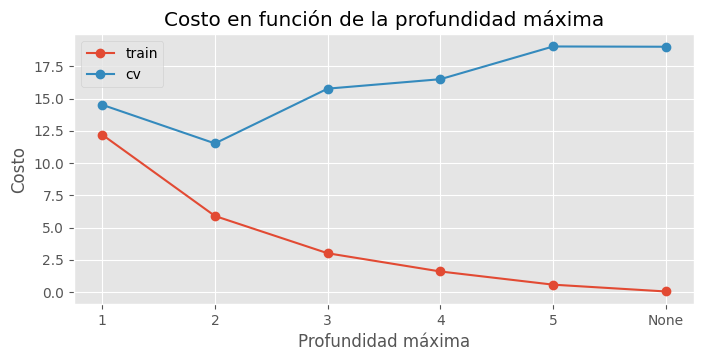

In [8]:
# Gráfica de evolución de MSE con profundidad
scores_df.plot(figsize=(8,3.5), marker='o')
plt.xlabel('Profundidad máxima')
plt.ylabel('Costo')
plt.xticks([0, 1, 2, 3, 4, 5], ['1', '2', '3', '4', '5', 'None'])
plt.title('Costo en función de la profundidad máxima')
plt.legend()
plt.show()

# Cost Complexity Pruning

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

In [10]:
# Árbol de profundidad None para comparación

tree = DecisionTreeRegressor(random_state=0)

In [11]:
mse_cv = -np.mean(cross_val_score(tree, X, y, cv=32, scoring='neg_mean_squared_error'))
print(f'MSE CV: {mse_cv:.3f}')

MSE CV: 19.023


In [12]:
# Ajustar el modelo
tree.fit(X, y)

DecisionTreeRegressor(random_state=0)

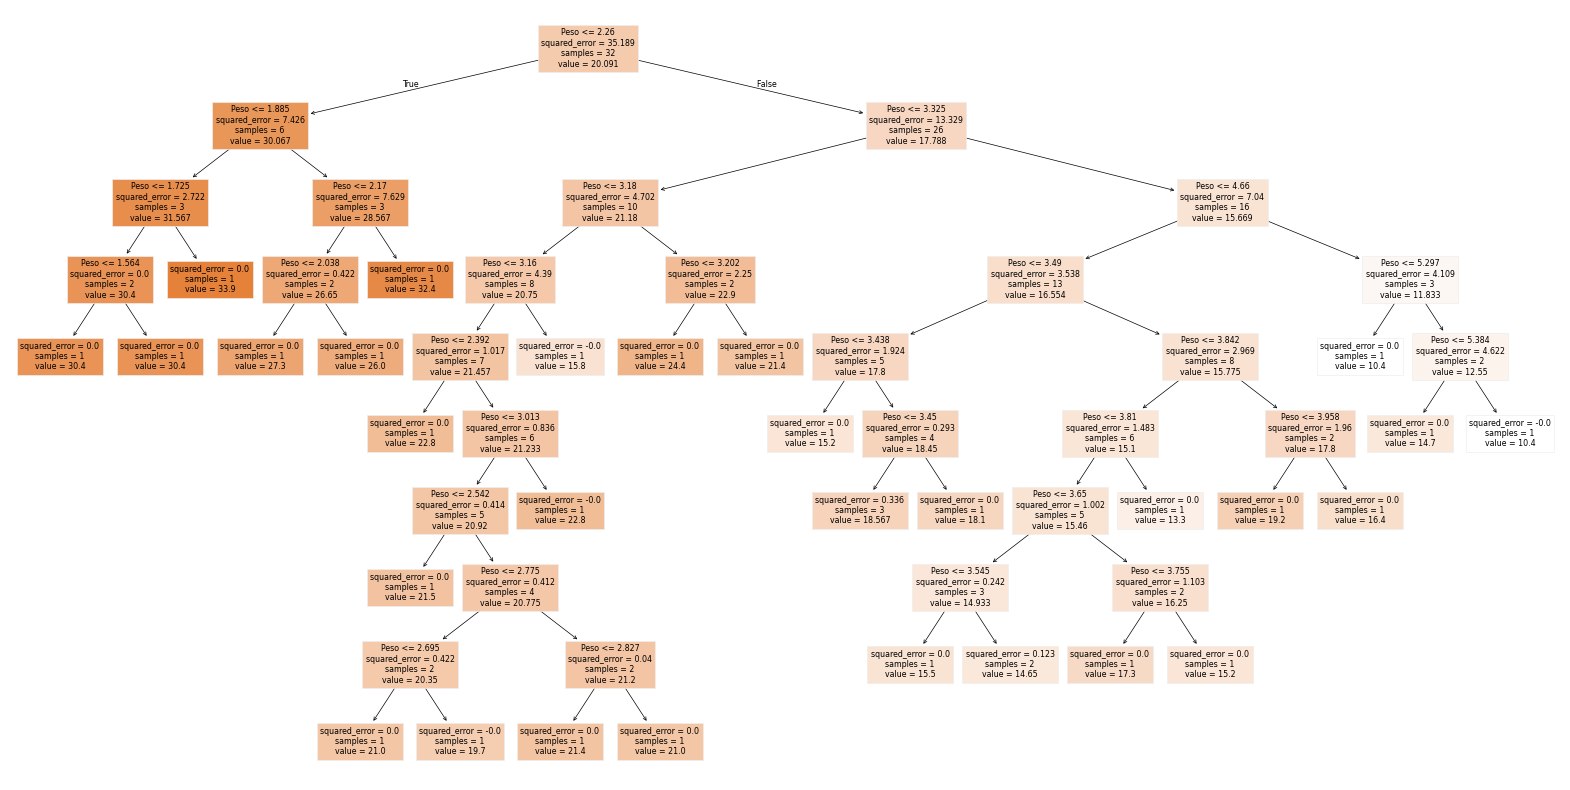

In [13]:
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=['Peso'], label='all', filled=True)
plt.show()

In [14]:
path = tree.cost_complexity_pruning_path(X, y)
alpha_list = path.ccp_alphas

In [15]:
tree_list = []
mse_alpha_list = []
for alpha in alpha_list:
    tree = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    tree.fit(X, y)
    tree_list.append(tree)
    mse_alpha = -np.mean(cross_val_score(tree, X, y, cv=len(X), scoring='neg_mean_squared_error'))
    mse_alpha_list.append(mse_alpha)
    print(f'Alpha: {alpha:.3f} - MSE CV: {mse_alpha:.3f}')

Alpha: 0.000 - MSE CV: 19.023
Alpha: 0.000 - MSE CV: 19.023
Alpha: 0.003 - MSE CV: 19.000
Alpha: 0.005 - MSE CV: 19.024
Alpha: 0.015 - MSE CV: 19.027
Alpha: 0.021 - MSE CV: 19.009
Alpha: 0.026 - MSE CV: 18.994
Alpha: 0.067 - MSE CV: 19.620
Alpha: 0.079 - MSE CV: 19.690
Alpha: 0.121 - MSE CV: 18.661
Alpha: 0.122 - MSE CV: 18.661
Alpha: 0.141 - MSE CV: 18.058
Alpha: 0.193 - MSE CV: 17.578
Alpha: 0.255 - MSE CV: 17.521
Alpha: 0.264 - MSE CV: 16.729
Alpha: 0.342 - MSE CV: 15.398
Alpha: 0.394 - MSE CV: 15.606
Alpha: 0.553 - MSE CV: 14.229
Alpha: 0.555 - MSE CV: 14.229
Alpha: 1.697 - MSE CV: 11.986
Alpha: 5.841 - MSE CV: 17.688
Alpha: 22.966 - MSE CV: 36.882


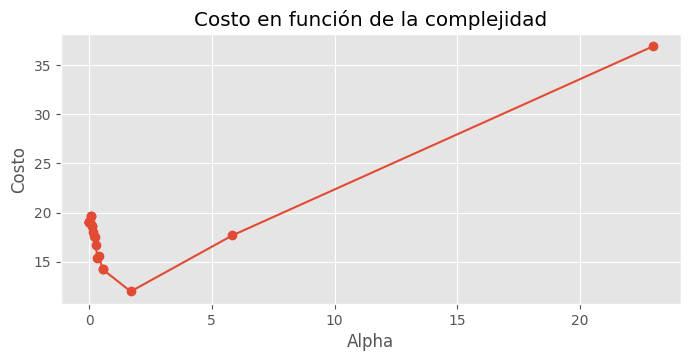

In [16]:
# Graficamos el error en CV en función de alpha
plt.figure(figsize=(8,3.5))
plt.plot(alpha_list, mse_alpha_list, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Costo')
plt.title('Costo en función de la complejidad')
plt.show()

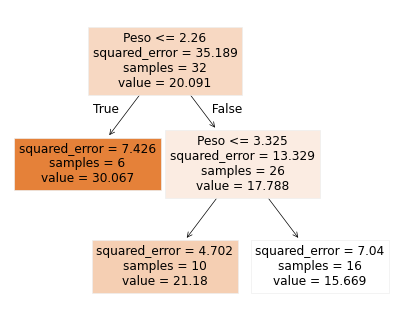

In [17]:
# Graficamos el arbol podado para cada alpha
plt.figure(figsize=(5,4))
tree = tree_list[-3]
plot_tree(tree, feature_names=['Peso'], label='all', filled=True)
plt.show()